<a href="https://colab.research.google.com/github/zdwhite/Thinkful-Unit-3/blob/master/Advanced_Regression_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Challenge Guidelines

1.   Pick a dataset of your choice with a binary outcome and the potential for at least 15 features. 

2.   Engineer your features, then create three models.
    *    Vanilla logistic regression
    *    Ridge logistic regression
    *    Lasso logistic regression

3.   Each model will be run on a training set and a test-set (or multiple test-sets, if you take a folds approach).

If you're stuck on how to begin combining your two new modeling skills, here's a hint: the SKlearn LogisticRegression method has a "penalty" argument that takes either 'l1' or 'l2' as a value.

4.   In your report, evaluate all three models and decide on your best. 
    *   Be clear about the decisions you made that led to these models (feature selection, regularization parameter selection, model evaluation criteria)
    *   Why you think that particular model is the best of the three.
    *   Also reflect on the strengths and limitations of regression as a modeling approach. 
    *   Were there things you couldn't do but you wish you could have done?


In [1]:
#Imports

#Basic Imports
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math

#Plotting
import seaborn as sns
%matplotlib inline
sns.set_style('white')

#Models
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm


#Data Infrastructure Pieces
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.model_selection import cross_val_score

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# The Data

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/zdwhite/Thinkful-Unit-3/master/WA_Fn-UseC_-Telco-Customer-Churn.csv')

##Telcom Customer Churn

The data was obtained from [Kaggle](https://www.kaggle.com/blastchar/telco-customer-churn)

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The raw data contains 7043 rows (customers) and 21 columns (features).

The “Churn” column is our target.



In [3]:
df.info()
# No null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

Quick note here is that **MonthlyCharges**  is type float , while **TotalCharges** is type object, this is a clear red flag of a data parity issue with in TotalCharges

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Cleaning / Preparation

A few things before we get started (in no particular order)

1.  customerID column should just be dropped as it's irrelevent
2.  There is a mix of text data that need's to be coded as integer values
3.  Get an understanding of class imbalance and in the process make sure text data is coded correctly

In [0]:
df.drop('customerID',axis=1,inplace=True)

In [6]:
df['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

In [0]:
# This cell is depretiated even though it's a nice way to get value counts for your columns
#df.apply(lambda x : print(x.value_counts(),'\n'))


In [7]:
# Shamlessly taken from Thinkful curriculum
categorical = df.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

gender
2
Partner
2
Dependents
2
PhoneService
2
MultipleLines
3
InternetService
3
OnlineSecurity
3
OnlineBackup
3
DeviceProtection
3
TechSupport
3
StreamingTV
3
StreamingMovies
3
Contract
3
PaperlessBilling
2
PaymentMethod
4
TotalCharges
6531
Churn
2


Mostly everything looks to be in working order except for the TotalCharges column discussed earlier

In [0]:
# Convert to numeric data
  df['TotalCharges'] =pd.to_numeric(df['TotalCharges'],errors='coerce')

In [9]:
# Looks like there are 11 null elements causing issues
df['TotalCharges'].isnull().sum()

11

In [10]:
# The offenders, it looks like the tenure of all these rows is 0 which could mean they have yet to be charged
# Let's check our assumption 
df[df['TotalCharges'].isnull()].equals(df[df['tenure']==0])

# Looks like we were correct these two "slices" are equivelent let's replace the nans with 0 as they have no total charge

True

In [0]:
# quick check on column wise null values
# df.apply(lambda x : print(x.name,'\n',x.isnull().sum(),'\n'))
# looks like no other null values in other columns i'm supressing the output so you don't have to scroll through it

df['TotalCharges'].fillna(0,inplace=True)

## Feature Engineering

In [0]:
# Get dummy variables, we really only want dummy variables for a select number of columns
# Lets populate that array now
# We want to change our yes no arrays to 0 1 and 

dummies = []
encode = []
categorical = df.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    if column.nunique() >2:
      dummies.append(i)
    if column.nunique() <=2:
      encode.append(i)


df = pd.get_dummies(df,columns=dummies)

df = pd.get_dummies(df,columns=encode,drop_first = True)

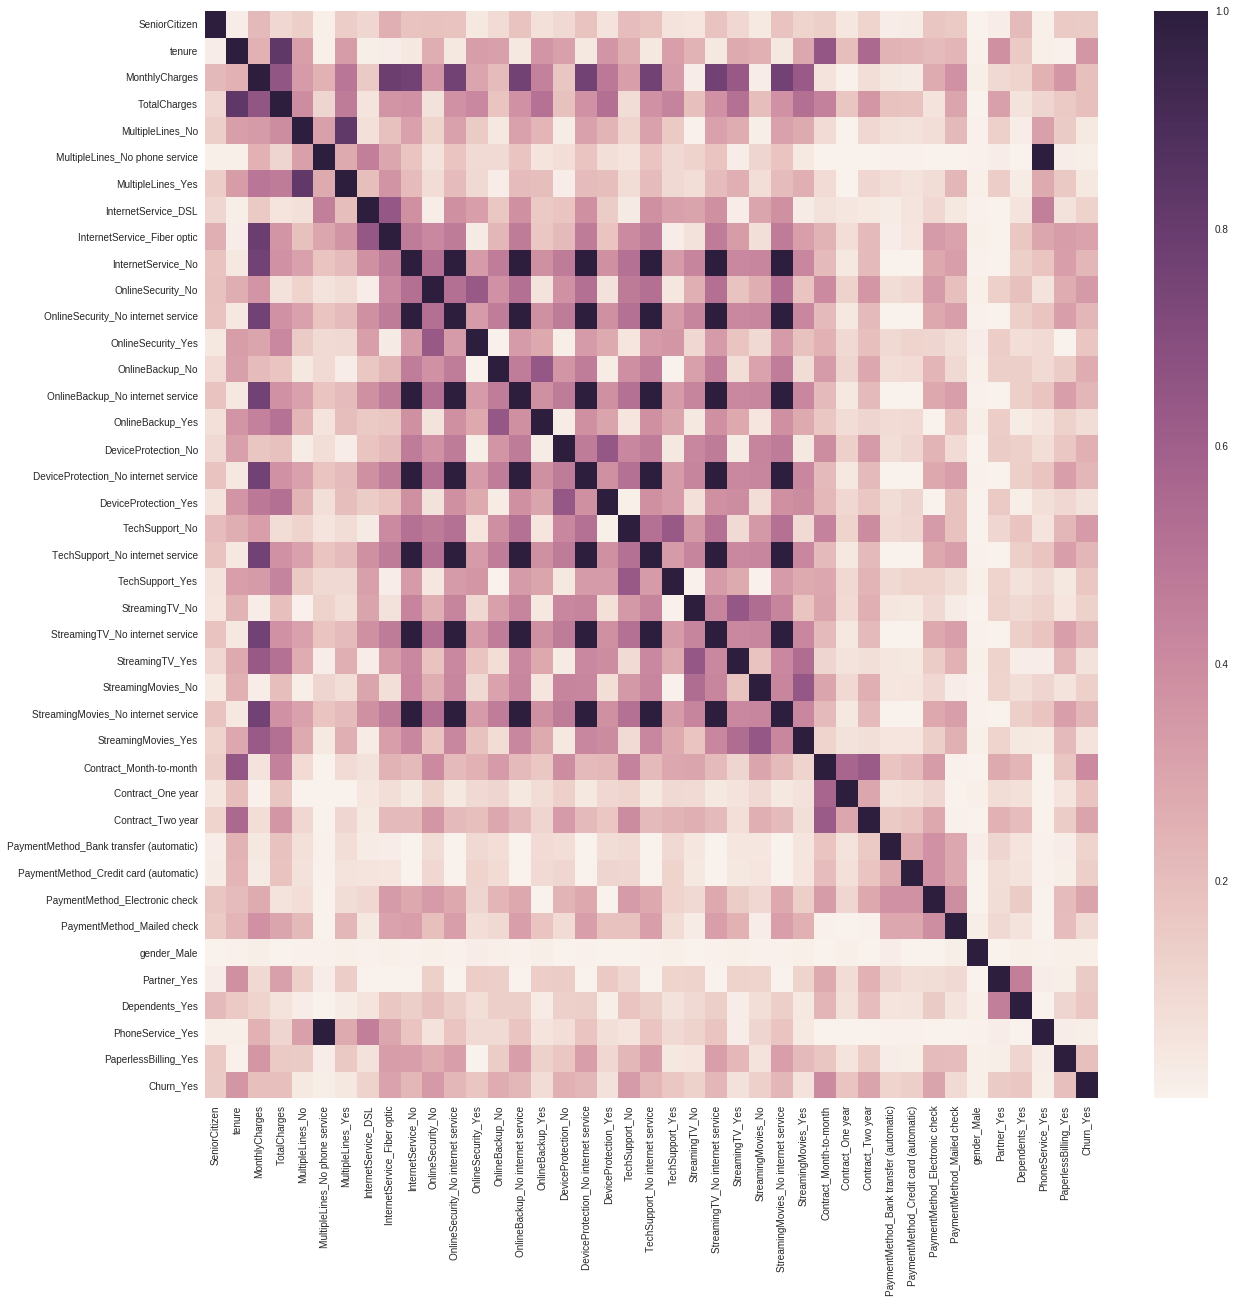

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
sns.heatmap(df.corr().abs())

Damnit there is a bunch of co-linearity here due to how data in this set is reported let's drop these usesless columns and only keep the "internetService_No" column

In [0]:
# Shamlessly taken from https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
# I've coded dictionary versions of this same fnuctionality but this is nice and pythonic

# Create correlation matrix
corr_matrix = df.corr().abs() 
#Select upper triangle of correlation matrix

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
# Drop features 
df = df.drop(to_drop, axis=1)

In [15]:
to_drop

['OnlineSecurity_No internet service',
 'OnlineBackup_No internet service',
 'DeviceProtection_No internet service',
 'TechSupport_No internet service',
 'StreamingTV_No internet service',
 'StreamingMovies_No internet service',
 'PhoneService_Yes']

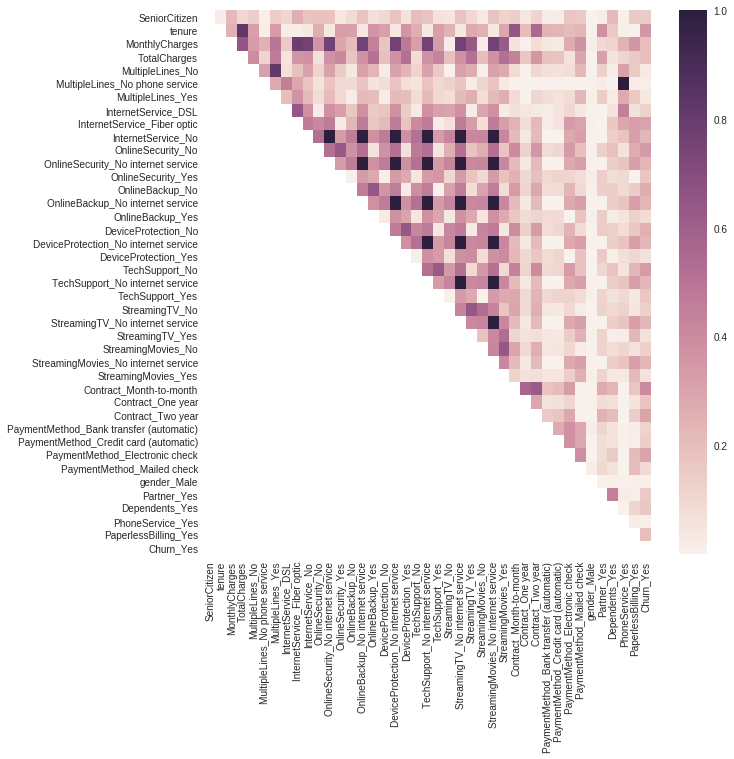

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
sns.heatmap(upper)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 34 columns):
SeniorCitizen                              7043 non-null int64
tenure                                     7043 non-null int64
MonthlyCharges                             7043 non-null float64
TotalCharges                               7043 non-null float64
MultipleLines_No                           7043 non-null uint8
MultipleLines_No phone service             7043 non-null uint8
MultipleLines_Yes                          7043 non-null uint8
InternetService_DSL                        7043 non-null uint8
InternetService_Fiber optic                7043 non-null uint8
InternetService_No                         7043 non-null uint8
OnlineSecurity_No                          7043 non-null uint8
OnlineSecurity_Yes                         7043 non-null uint8
OnlineBackup_No                            7043 non-null uint8
OnlineBackup_Yes                           7043 non-null uint8
DeviceP

In [18]:
df.apply(lambda x:print(x.describe()))

count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: SeniorCitizen, dtype: float64
count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64
count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64
count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64
count    7043.000000
mean        0.481329
std         0.499687
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: MultipleLines_No,

SeniorCitizen                              None
tenure                                     None
MonthlyCharges                             None
TotalCharges                               None
MultipleLines_No                           None
MultipleLines_No phone service             None
MultipleLines_Yes                          None
InternetService_DSL                        None
InternetService_Fiber optic                None
InternetService_No                         None
OnlineSecurity_No                          None
OnlineSecurity_Yes                         None
OnlineBackup_No                            None
OnlineBackup_Yes                           None
DeviceProtection_No                        None
DeviceProtection_Yes                       None
TechSupport_No                             None
TechSupport_Yes                            None
StreamingTV_No                             None
StreamingTV_Yes                            None
StreamingMovies_No                      

# The Models

##  Test Train Split

In [0]:
X = df.drop('Churn_Yes',axis = 1)
Y = df['Churn_Yes']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25)

In [20]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
SeniorCitizen                              7043 non-null int64
tenure                                     7043 non-null int64
MonthlyCharges                             7043 non-null float64
TotalCharges                               7043 non-null float64
MultipleLines_No                           7043 non-null uint8
MultipleLines_No phone service             7043 non-null uint8
MultipleLines_Yes                          7043 non-null uint8
InternetService_DSL                        7043 non-null uint8
InternetService_Fiber optic                7043 non-null uint8
InternetService_No                         7043 non-null uint8
OnlineSecurity_No                          7043 non-null uint8
OnlineSecurity_Yes                         7043 non-null uint8
OnlineBackup_No                            7043 non-null uint8
OnlineBackup_Yes                           7043 non-null uint8
DeviceP

## Vanilla logistic regression

In [21]:
# Declare predictors.
X_statsmod = X_train.copy()

# The Statsmodels formulation requires a column with constant value 1 that
# will act as the intercept.
#X_statsmod['intercept'] = 1 

# Declare and fit the model.
logit = sm.Logit(Y_train, X_statsmod)
result = logit.fit(maxiter=1000)

# Lots of information about the model and its coefficients, but the
# accuracy rate for predictions is missing.
print(result.summary2())

Optimization terminated successfully.
         Current function value: inf
         Iterations 61
                                            Results: Logit
Model:                          Logit                        No. Iterations:               61.0000    
Dependent Variable:             Churn_Yes                    Pseudo R-squared:             -inf       
Date:                           2018-12-31 22:16             AIC:                          inf        
No. Observations:               5282                         BIC:                          inf        
Df Model:                       23                           Log-Likelihood:               -inf       
Df Residuals:                   5258                         LL-Null:                      -9.9806e+05
Converged:                      1.0000                       Scale:                        1.0000     
------------------------------------------------------------------------------------------------------
                   

/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1264: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1029: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 34 columns):
SeniorCitizen                              7043 non-null int64
tenure                                     7043 non-null int64
MonthlyCharges                             7043 non-null float64
TotalCharges                               7043 non-null float64
MultipleLines_No                           7043 non-null uint8
MultipleLines_No phone service             7043 non-null uint8
MultipleLines_Yes                          7043 non-null uint8
InternetService_DSL                        7043 non-null uint8
InternetService_Fiber optic                7043 non-null uint8
InternetService_No                         7043 non-null uint8
OnlineSecurity_No                          7043 non-null uint8
OnlineSecurity_Yes                         7043 non-null uint8
OnlineBackup_No                            7043 non-null uint8
OnlineBackup_Yes                           7043 non-null uint8
DeviceP

In [23]:
# Calculate accuracy. First, get probability that each row will be admitted.
pred_statsmod = result.predict(X_statsmod)

# Code admission as 1 if probability is greater than .5.
pred_Y_statsmod = np.where(pred_statsmod < .5, 0, 1)

# Accuracy table.
table = pd.crosstab( pred_Y_statsmod,Y_train)

print('\n Accuracy by admission status')
print(table)
print('\n Percentage accuracy')
print((table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum()))


 Accuracy by admission status
Churn_Yes     0    1
row_0               
0          3470  627
1           401  784

 Percentage accuracy
0.8053767512305945


## Ridge logistic regression

In [24]:
ridgemodel = LogisticRegression(C=10, penalty='l2',solver = 'liblinear')
ridgemodel.fit(X_train, Y_train)
y_pred=ridgemodel.predict(X_test)
ridgemodel.score(X_test, Y_test)

0.8006814310051107

In [25]:
confusion_matrix(y_pred, Y_test)

array([[1165,  213],
       [ 138,  245]])

### Cross Validation

In [26]:
print(cross_val_score(ridgemodel, X_test, Y_test, cv=5))

[0.8101983  0.75637394 0.78753541 0.81481481 0.8034188 ]


## LASSO Regression

In [32]:
lassoR = LogisticRegression(C=.8, penalty='l1',solver = 'liblinear')
lassoR.fit(X_train, Y_train)
y_pred=lassoR.predict(X_test)
lassoR.score(X_test, Y_test)

0.8023850085178875

In [33]:
confusion_matrix(y_pred, Y_test)

array([[1168,  213],
       [ 135,  245]])

### Cross Validation

In [34]:
print(cross_val_score(lassoR, X_test, Y_test, cv=5))

[0.80736544 0.7592068  0.78753541 0.8034188  0.79487179]
